# Creación de indicadores técnicos

In [ ]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Optional, Sequence, Mapping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, Sequential


# ==========================================================
# 1) INDICADORES TÉCNICOS
# ==========================================================
def make_tech_indicators(
    data,
    price_col: str = "Close",
    high_col: str = "High",
    low_col: str = "Low",
    vol_col: str = "Volume",
    safe: bool = True,          # anti-fuga: shift(1) de todos los features
    reset_index: bool = True    # agrega columna Date en vez de dejar índice datetime
) -> pd.DataFrame:
    """
    Dada una serie temporal (pd.Series con precios o pd.DataFrame OHLCV),
    retorna un DataFrame con columnas: Date, Price, <indicadores...>.
    Todos los features quedan calculados solo con info hasta t
    (y si safe=True se desplazan 1 día para predecir t+1).
    """

    # ---------- Normalización de entrada ----------
    if isinstance(data, pd.Series):
        df = data.to_frame(name=price_col).copy()
    else:
        df = data.copy()

    if df.index.name is None:
        df.index.name = "Date"
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Asegura columnas esperadas y dtypes
    for c in [price_col, high_col, low_col, vol_col]: # Convertir las columnas al tipo de dato adecuado
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")
    if price_col not in df.columns: # Caso en que no haya columna de precios
        raise ValueError(f"Falta columna de precio '{price_col}'")

    has_hl = (high_col in df.columns) and (low_col in df.columns)  # Tiene high y low
    has_vol = vol_col in df.columns # Tiene columna de volumne

    # Alias locales
    close = df[price_col]
    high  = df[high_col] if has_hl else None
    low   = df[low_col]  if has_hl else None
    vol   = df[vol_col].replace(0, np.nan).astype("float64") if has_vol else None

    # ---------- Helpers internos ----------
    ema = lambda s, span: s.ewm(span=span, adjust=False).mean()

    def true_range():
        prev_close = close.shift(1) # Los valores se desplazan una vez, ahora cada casilla, significa: "el valor de ayer"
        tr1 = (high - low) if has_hl else (close - close) * np.nan
        tr2 = (high - prev_close).abs() if has_hl else (close - prev_close).abs()
        tr3 = (low - prev_close).abs() if has_hl else (prev_close - close).abs()
        return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    def rsi(n=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/n, min_periods=n, adjust=False).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        return (100 - (100 / (1 + rs))).fillna(50.0)

    def stochastic(n=14, d=3):
        if not has_hl:
            return pd.Series(np.nan, index=df.index), pd.Series(np.nan, index=df.index)
        low_n = low.rolling(n).min()
        high_n = high.rolling(n).max()
        den = (high_n - low_n).replace(0, np.nan)
        k = 100 * (close - low_n) / den
        dline = k.rolling(d).mean()
        return k, dline

    def bollinger(n=20, k=2):
        ma = close.rolling(n).mean()
        sd = close.rolling(n).std()
        upper, lower = ma + k*sd, ma - k*sd
        bw = (upper - lower) / ma
        den = (upper - lower).replace(0, np.nan)
        pb = (close - lower) / den
        return bw, pb

    def adx_block(n=14):
        if not has_hl:
            nan = pd.Series(np.nan, index=df.index)
            return nan, nan, nan, nan
        up_move = high.diff()
        down_move = -low.diff()
        plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
        minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)
        tr = true_range()
        atr = tr.ewm(alpha=1/n, adjust=False).mean().replace(0, np.nan)
        plus_di = 100 * pd.Series(plus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        minus_di = 100 * pd.Series(minus_dm, index=df.index).ewm(alpha=1/n, adjust=False).mean() / atr
        den = (plus_di + minus_di).replace(0, np.nan)
        dx = 100 * (plus_di - minus_di).abs() / den
        adx = dx.ewm(alpha=1/n, adjust=False).mean()
        return atr, adx, plus_di, minus_di

    def obv():
        if not has_vol:
            return pd.Series(np.nan, index=df.index)
        return (np.sign(close.diff()).fillna(0) * vol.fillna(0)).cumsum()

    def mfi(n=14):
        if not (has_hl and has_vol):
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        mf = tp * vol.fillna(0.0)
        pos_flow = np.where(tp > tp.shift(1), mf, 0.0)
        neg_flow = np.where(tp < tp.shift(1), mf, 0.0)
        pos = pd.Series(pos_flow, index=df.index, dtype="float64").rolling(n).sum()
        neg = pd.Series(neg_flow, index=df.index, dtype="float64").rolling(n).sum()
        mfr = pos / neg.replace(0, np.nan)
        return (100 - (100 / (1 + mfr))).fillna(50.0)

    def cci(n=20):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        tp = (high + low + close) / 3.0
        sma = tp.rolling(n).mean()
        mad = (tp - sma).abs().rolling(n).mean()
        return (tp - sma) / (0.015 * mad)

    def williams_r(n=14):
        if not has_hl:
            return pd.Series(np.nan, index=df.index)
        hh = high.rolling(n).max()
        ll = low.rolling(n).min()
        denom = (hh - ll).replace(0, np.nan)
        return -100 * (hh - close) / denom

    # ---------- Cálculo de indicadores ----------
    out = pd.DataFrame(index=df.index)
    out["Price"] = close.astype("float64")
    
    out["Open"] = df["Open"].astype("float64") if "Open" in df.columns else np.nan
    out["High"] = high if has_hl else np.nan
    out["Low"] = low if has_hl else np.nan
    out["Volume"] = df[vol_col] if has_vol else np.nan

    # Tendencia
    for n in [5, 10, 20, 50, 200]:
        out[f"SMA_{n}"] = close.rolling(n).mean()
    for n in [5, 10, 20, 50]:
        out[f"EMA_{n}"] = ema(close, n)

    macd = ema(close, 12) - ema(close, 26)
    macd_sig = ema(macd, 9)
    out["MACD"] = macd
    out["MACD_signal"] = macd_sig
    out["MACD_hist"] = macd - macd_sig

    # Momentum
    for h in [1, 5, 10]:
        out[f"ROC_{h}"] = (close - close.shift(h)) / close.shift(h)
        out[f"MOM_{h}"] = close - close.shift(h)
    out["RSI_14"] = rsi(14)

    # Volatilidad y bandas
    out["VOL_20"] = np.log(close / close.shift(1)).rolling(20).std()
    bw, pb = bollinger(20, 2)
    out["BB_BW"] = bw
    out["BB_PB"] = pb

    # Osciladores con H/L
    k, d = stochastic(14, 3)
    out["STOCH_K"] = k
    out["STOCH_D"] = d
    out["WILLR_14"] = williams_r(14)
    out["CCI_20"] = cci(20)

    # Rango y dirección
    atr, adx, plus_di, minus_di = adx_block(14)
    out["ATR_14"] = atr
    out["ADX_14"] = adx
    out["PLUS_DI"] = plus_di
    out["MINUS_DI"] = minus_di

    # Flujo / volumen
    out["OBV"] = obv()
    out["MFI_14"] = mfi(14)

    # Extras livianos
    out["BIAS_12"] = (close - close.rolling(12).mean()) / close.rolling(12).mean()
    updays = (close.diff() > 0).astype(int)
    out["PSY_12"] = 100 * updays.rolling(12).mean()
    # BBI (promedio SMA 3,6,12,24)
    out["BBI"] = (close.rolling(3).mean() + close.rolling(6).mean() +
                  close.rolling(12).mean() + close.rolling(24).mean()) / 4.0
    # CHO (Chaikin Oscillator)
    if has_hl and has_vol:
        clv = ((close - low) - (high - close)) / (high - low)
        clv = clv.replace([np.inf, -np.inf], np.nan).fillna(0)
        adl = (clv * vol.fillna(0)).cumsum()
        out["CHO_3_10"] = ema(adl, 3) - ema(adl, 10)
    else:
        out["CHO_3_10"] = np.nan

    # MASS / WVAD / AR-BR / CR (si hay H/L/V)
    if has_hl:
        diff_hl = (high - low).abs()
        e1 = diff_hl.ewm(span=9, adjust=False).mean()
        e2 = e1.ewm(span=9, adjust=False).mean()
        ratio = e1 / e2.replace(0, np.nan)
        out["MASS_25"] = ratio.rolling(25).sum()
    else:
        out["MASS_25"] = np.nan

    if has_hl and has_vol:
        rng = (high - low).replace(0, np.nan)
        out["WVAD_24"] = (((close - df.get("Open", close)) / rng) * vol).rolling(24).sum()

        ar_num = (high - df.get("Open", close)).rolling(26).sum()
        ar_den = (df.get("Open", close) - low).rolling(26).sum().replace(0, np.nan)
        out["AR_26"] = 100 * ar_num / ar_den

        cp = close.shift(1)
        br_num = (high - cp).rolling(26).sum()
        br_den = (cp - low).rolling(26).sum().replace(0, np.nan)
        out["BR_26"] = 100 * br_num / br_den

        mid = (high + low + 2*close) / 4
        mid_y = mid.shift(1)
        up = (high - mid_y).clip(lower=0)
        down = (mid_y - low).clip(lower=0)
        out["CR_26"] = 100 * up.rolling(26).sum() / down.rolling(26).sum().replace(0, np.nan)
    else:
        out["WVAD_24"] = np.nan
        out["AR_26"] = np.nan
        out["BR_26"] = np.nan
        out["CR_26"] = np.nan

    # ---------- Anti-fuga ----------
    if safe:
        feat_cols = [c for c in out.columns if c != "Price"]
        out[feat_cols] = out[feat_cols].shift(1)

    # ---------- Limpieza ----------
    out = out.astype("float64")
    out = out.replace([np.inf, -np.inf], np.nan)
    out = out.dropna().copy()

    if reset_index:
        out = out.rename_axis("Date").reset_index()

    return out



| **Indicador** | **Fórmula** | **Descripción / Interpretación** |
|----------------|-------------|----------------------------------|
| **SMA (Simple Moving Average)** | $ SMA_t = \frac{1}{n}\sum_{i=0}^{n-1} P_{t-i} $ | Promedio simple de precios. Suaviza ruido y muestra tendencia general. |
| **EMA (Exponential Moving Average)** | $ EMA_t = \alpha P_t + (1-\alpha) EMA_{t-1}, \ \alpha = \frac{2}{n+1} $ | Promedio ponderado que da más importancia a precios recientes. |
| **MACD (Moving Average Convergence Divergence)** | $ MACD_t = EMA_{12} - EMA_{26}, \ Signal_t = EMA_9(MACD_t) $ | Mide convergencia/divergencia entre medias móviles; cruces indican cambios de tendencia. |
| **ROC (Rate of Change)** | $ ROC_t = \frac{P_t - P_{t-n}}{P_{t-n}} $ | Tasa de cambio porcentual del precio; mide momentum relativo. |
| **MOM (Momentum)** | $ MOM_t = P_t - P_{t-n} $ | Diferencia absoluta del precio en $n$ periodos; fuerza del movimiento. |
| **RSI (Relative Strength Index)** | $ RSI_t = 100 - \frac{100}{1 + RS}, \ RS = \frac{\text{promedio ganancias}}{\text{promedio pérdidas}} $ | Oscilador 0–100; sobrecompra >70, sobreventa <30. |
| **PSY (Psychological Line)** | $ PSY_t = 100 \times \frac{\#(P_t > P_{t-1})}{n} $ | Porcentaje de días con cierre al alza; mide sentimiento del mercado. |
| **VOL (Volatilidad 20d)** | $ VOL_t = \sigma\left(\ln\frac{P_t}{P_{t-1}}\right)_{20} $ | Desviación estándar de los retornos logarítmicos a 20 días. |
| **Bollinger Bands (BW, PB)** | $ BW = \frac{U-L}{MA}, \ PB = \frac{P-L}{U-L}, \ U=MA+k\sigma, L=MA-k\sigma $ | Ancho de banda (volatilidad) y posición del precio dentro del canal. |
| **Stochastic Oscillator (K, D)** | $ \%K = 100\frac{P - L_n}{H_n - L_n}, \%D = SMA_3(\%K) $ | Relación del cierre actual con el rango de precios reciente; detecta extremos. |
| **Williams %R** | $ \%R = -100\frac{H_n - P}{H_n - L_n} $ | Similar al Stochastic; sobrecompra/sobreventa. |
| **CCI (Commodity Channel Index)** | $ CCI = \frac{TP - SMA(TP)}{0.015 \times MAD(TP)}, \ TP=\frac{H+L+C}{3} $ | Mide la desviación del precio respecto a su promedio típico. |
| **ATR (Average True Range)** | $ ATR = EMA(TR), \ TR=\max(H-L, |H-C_{t-1}|, |L-C_{t-1}|) $ | Volatilidad “real” considerando huecos (gaps). |
| **ADX (Average Directional Index)** | $ ADX = EMA\left(100\frac{|+DI - -DI|}{+DI + -DI}\right) $ | Mide la fuerza de la tendencia (sin dirección). |
| **+DI / -DI (Directional Indicators)** | $ +DI = 100\frac{EMA(+DM)}{ATR}, \ -DI = 100\frac{EMA(-DM)}{ATR} $ | Miden presión compradora (+DI) o vendedora (-DI). |
| **OBV (On-Balance Volume)** | $ OBV_t = OBV_{t-1} + \text{sign}(P_t - P_{t-1})V_t $ | Acumula volumen según dirección del precio; confirma tendencias. |
| **MFI (Money Flow Index)** | $ MFI = 100 - \frac{100}{1 + \frac{\sum MF^+}{\sum MF^-}} $, $ MF=TP\times V $ | RSI ponderado por volumen; mide flujo de dinero. |
| **BIAS** | $ BIAS = \frac{P - SMA_n(P)}{SMA_n(P)} $ | Desviación porcentual del precio respecto a su media. |
| **BBI (Bull and Bear Index)** | $ BBI = \frac{SMA_3 + SMA_6 + SMA_{12} + SMA_{24}}{4} $ | Promedio de 4 SMAs; muestra tendencia de medio plazo. |
| **CHO (Chaikin Oscillator)** | $ CHO = EMA_3(ADL) - EMA_{10}(ADL), \ ADL = \sum (CLV \times V) $ | Detecta acumulación/distribución mediante volumen y rango. |
| **MASS Index** | $ MASS = \sum_{i=0}^{25} \frac{EMA_9(H-L)}{EMA_9(EMA_9(H-L))} $ | Detecta posibles reversiones de tendencia por expansión del rango. |
| **WVAD (Williams Variable A/D)** | $ WVAD = \sum \frac{(C - O)}{H - L} \times V $ | Mide presión de compra/venta combinando rango y volumen. |
| **AR** | $ AR = 100 \frac{\sum(H - O)}{\sum(O - L)} $ | Evalúa fuerza interna de compradores vs. vendedores. |
| **BR** | $ BR = 100 \frac{\sum(H - C_{t-1})}{\sum(C_{t-1} - L)} $ | Evalúa fuerza externa de reacción del mercado. |
| **CR (Energy Index)** | $ CR = 100 \frac{\sum(H - MID_{t-1})}{\sum(MID_{t-1} - L)} $, $ MID=\frac{H+L+2C}{4} $ | Variante que mide presión compradora mediante media desplazada. |

---

### 🧠 Notas
- Todos los indicadores se **desplazan 1 paso (`shift(1)`)** cuando `safe=True`, para evitar fuga temporal.  
- Los que requieren `High`, `Low` o `Volume` devuelven `NaN` si faltan esas columnas.  
- Los primeros valores se pierden por ventanas de cálculo (`rolling`, `EMA`).  
- Todos los resultados son `float64` y listos para modelado o análisis.

# Funciones para tratar series de tiempo

In [ ]:
# ==========================================================
# 2) CORE TIME-SERIES: build_xy, splits, escaladores, secuencias
# ==========================================================
def build_xy(features_df: pd.DataFrame):
    """
    A partir de features técnicos devuelve:
    - X: todas las columnas de features (incluyendo Price).
    - y: Price_next = Price(t+1).
    """
    df = features_df.copy()
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()

    df["Price_next"] = df["Price"].shift(-1)
    df = df.dropna()

    y = df["Price_next"].astype(float)
    X = df.drop(columns=["Price_next"])

    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
    if const_cols:
        X = X.drop(columns=const_cols)

    assert X.index.equals(y.index)
    return X, y

@dataclass
class SplitDates:
    train_end: str
    val_end: str
    test_end: Optional[str] = None  # si None, test = resto posterior a val_end

def time_splits(X: pd.DataFrame, y: pd.Series, dates: SplitDates):
    idx = X.index
    train = idx <= pd.to_datetime(dates.train_end)
    val   = (idx > pd.to_datetime(dates.train_end)) & (idx <= pd.to_datetime(dates.val_end))
    test  = idx > pd.to_datetime(dates.val_end) if dates.test_end is None else (
            (idx > pd.to_datetime(dates.val_end)) & (idx <= pd.to_datetime(dates.test_end)))
    return (X.loc[train], y.loc[train]), (X.loc[val], y.loc[val]), (X.loc[test], y.loc[test])

class TimeScaler:
    """
    MinMax para X, fit SOLO en train.
    """
    def __init__(self, feature_range=(0, 1)):
        self.scaler = MinMaxScaler(feature_range=feature_range)
        self.cols_: list[str] = []

    def fit(self, X_train: pd.DataFrame):
        self.scaler.fit(X_train.values)
        self.cols_ = list(X_train.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        missing = [c for c in self.cols_ if c not in X.columns]
        extra   = [c for c in X.columns if c not in self.cols_]
        assert not missing, f"Faltan columnas para transformar: {missing}"
        if extra:
            print(f"[AVISO] Columnas extra ignoradas en transform: {extra}")
        X2 = X[self.cols_].values
        return self.scaler.transform(X2)

class TimeScalerY:
    """
    MinMax para y, fit SOLO en train.
    """
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, y_train):
        self.scaler.fit(y_train.reshape(-1, 1))
        return self

    def transform(self, y):
        return self.scaler.transform(y.reshape(-1, 1)).flatten()

    def inverse(self, y_scaled):
        return self.scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()

def make_sequences(
    X_arr: np.ndarray,
    y_arr: np.ndarray,
    dates_arr: np.ndarray,
    lookback: int = 60,
):
    """
    Cada muestra: ventana [t-lookback+1 ... t] -> predice y[t].
    """
    n = len(y_arr)
    X_seq, y_seq, d_seq = [], [], []

    for t in range(lookback - 1, n):
        X_seq.append(X_arr[t - lookback + 1:t + 1, :])
        y_seq.append(y_arr[t])
        d_seq.append(dates_arr[t])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(d_seq),
    )

@dataclass
class LSTMPrepConfig:
    lookback: int = 5
    horizon: int = 1  # solo informativo
    selected_features: Optional[Sequence[str]] = None

def prepare_lstm_data(
    features_df: pd.DataFrame,
    split_dates: SplitDates,
    cfg: LSTMPrepConfig = LSTMPrepConfig(),
):
    """
    Construye secuencias escaladas para LSTM / modelos tabulares (flattened).
    """
    X, y = build_xy(features_df)

    if cfg.selected_features is not None:
        keep = [c for c in cfg.selected_features if c in X.columns]
        X = X[keep]
        assert list(X.columns) == keep

    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = time_splits(X, y, split_dates)

    scaler_x = TimeScaler().fit(X_tr)
    X_all_scaled = scaler_x.transform(X)

    y_all    = y.values.astype(np.float32)
    y_tr_arr = y_tr.values.astype(np.float32)

    scaler_y      = TimeScalerY().fit(y_tr_arr)
    y_all_scaled  = scaler_y.transform(y_all)
    dates_all     = X.index.to_numpy()

    X_seq, y_seq, d_seq = make_sequences(
        X_all_scaled,
        y_all_scaled,
        dates_all,
        lookback=cfg.lookback,
    )

    train_end_dt = pd.to_datetime(split_dates.train_end)
    val_end_dt   = pd.to_datetime(split_dates.val_end)
    test_end_dt  = pd.to_datetime(split_dates.test_end) if split_dates.test_end is not None else None

    train_mask = d_seq <= train_end_dt
    val_mask   = (d_seq > train_end_dt) & (d_seq <= val_end_dt)
    test_mask  = d_seq > val_end_dt if test_end_dt is None else (
                 (d_seq > val_end_dt) & (d_seq <= test_end_dt))

    Xtr_seq, ytr_seq = X_seq[train_mask], y_seq[train_mask]
    Xva_seq, yva_seq = X_seq[val_mask], y_seq[val_mask]
    Xte_seq, yte_seq = X_seq[test_mask], y_seq[test_mask]

    return {
        "X_train": Xtr_seq,
        "y_train": ytr_seq,
        "X_val":   Xva_seq,
        "y_val":   yva_seq,
        "X_test":  Xte_seq,
        "y_test":  yte_seq,
        "scaler_x":  scaler_x,
        "scaler_y":  scaler_y,
        "feature_cols": list(X.columns),
        "lookback": cfg.lookback,
        "horizon": 1,
        "dates_seq": d_seq,
    }

def prepare_tabular_from_lstm_prep(prep_dict):
    """
    Convierte tensores 3D (ventanas) a matrices 2D para sklearn.
    """
    def _flat(Xseq):
        n, L, f = Xseq.shape
        return Xseq.reshape(n, L * f)

    Xtr = _flat(prep_dict["X_train"])
    Xva = _flat(prep_dict["X_val"])
    Xte = _flat(prep_dict["X_test"])
    ytr = prep_dict["y_train"]
    yva = prep_dict["y_val"]
    yte = prep_dict["y_test"]
    return Xtr, ytr, Xva, yva, Xte, yte 


# Algoritmo Genético

In [20]:
# === GA para selección de features con series de tiempo ===
# Requisitos: numpy, pandas, scikit-learn
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from dataclasses import dataclass
from sklearn.metrics import r2_score



In [21]:
# ----------------------------------------------------------
# Utilidades
# ----------------------------------------------------------

def evaluar_subset_TS(X: pd.DataFrame, y: pd.Series, mask: np.ndarray, n_splits=5) -> float:
    """
    Evalúa un subconjunto de columnas (mask booleana) con:
    - Escalado (StandardScaler)
    - Ridge
    - TimeSeriesSplit

    Devuelve fitness = R² medio en los folds.
    Si el subset es vacío o casi vacío, aplica una penalización fuerte.
    """
    sel_cols = X.columns[mask]
    if len(sel_cols) < 3:  # penaliza cromosomas raquíticos
        return -1e9

    Xs = X[sel_cols].values
    ys = y.values

    tscv = TimeSeriesSplit(n_splits=n_splits)
    modelo = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("reg", Ridge(alpha=1.0))
    ])

    r2_list = []

    for tr_idx, te_idx in tscv.split(Xs):
        Xtr, Xte = Xs[tr_idx], Xs[te_idx]
        ytr, yte = ys[tr_idx], ys[te_idx]

        # Ajusta solo en train, respeta el orden temporal
        modelo.fit(Xtr, ytr)
        pr = modelo.predict(Xte)

        r2 = r2_score(yte, pr)
        r2_list.append(r2)

    if not r2_list:
        return -1e9

    r2_mean = float(np.mean(r2_list))

    if not np.isfinite(r2_mean):
        r2_mean = -1e9

    # Fitness del GA = R² medio
    return r2_mean


def _multipoint_crossover(p1: np.ndarray, p2: np.ndarray, n_points=2):
    """
    Cruce multipunto: corta y alterna segmentos.
    """
    L = len(p1)
    if L < 2: 
        return p1.copy(), p2.copy()
    # puntos de corte únicos entre 1 y L-1
    pts = np.sort(np.random.choice(np.arange(1, L), size=min(n_points, max(1, L-1)), replace=False))
    child1, child2 = p1.copy(), p2.copy()
    swap = False
    last = 0
    for pt in list(pts) + [L]:
        if swap:
            child1[last:pt], child2[last:pt] = p2[last:pt], p1[last:pt]
        last = pt
        swap = not swap
    return child1, child2

def _bitflip_mutation(ind: np.ndarray, p=0.003):
    flips = np.random.rand(ind.size) < p
    ind[flips] = ~ind[flips]
    return ind

def _ensure_min_features(ind: np.ndarray, kmin=3):
    # Si hay menos de kmin bits en 1, enciende aleatorios
    on = ind.sum()
    if on < kmin:
        idx0 = np.where(~ind)[0]
        if idx0.size > 0:
            turn_on = np.random.choice(idx0, size=min(kmin-on, idx0.size), replace=False)
            ind[turn_on] = True
    return ind

@dataclass
class GAConfig:
    pop_size: int = 100
    p_crossover: float = 0.8
    p_mutation: float = 0.06
    generations: int = 100
    n_points_cx: int = 2
    elitism: int = 1
    min_features: int = 3
    n_splits_cv: int = 5
    random_state: int = 42

class GASelector:
    def __init__(self, X: pd.DataFrame, y: pd.Series, cfg: GAConfig):
        self.X = X
        self.y = y
        self.cfg = cfg
        np.random.seed(cfg.random_state)
        self.n_feat = X.shape[1]
        # población booleana inicial ~50% activos
        self.pop = np.random.rand(cfg.pop_size, self.n_feat) < 0.5
        for i in range(cfg.pop_size):
            self.pop[i] = _ensure_min_features(self.pop[i], cfg.min_features)

        self.history_best = []   # (gen, fitness, mask)
        self.history_scores = [] # lista fitness por generación

    def _fitness_all(self, pop):
        fits = np.zeros(pop.shape[0], dtype=float)
        for i, mask in enumerate(pop):
            fits[i] = evaluar_subset_TS(self.X, self.y, mask, n_splits=self.cfg.n_splits_cv)
        return fits

    def _roulette_select(self, fits, k):
        # probabilidades proporcionales al fitness, con epsilon por si acaso
        f = np.array(fits, dtype=float)
        f = f - f.min() + 1e-12
        p = f / f.sum() if f.sum() > 0 else np.ones_like(f) / len(f)
        idx = np.random.choice(len(f), size=k, replace=True, p=p)
        return idx

    def run(self):
        cfg = self.cfg
        pop = self.pop.copy()
        for gen in range(cfg.generations):
            fits = self._fitness_all(pop)
            self.history_scores.append(fits)

            # guarda mejor de la generación
            ibest = int(np.argmax(fits))
            self.history_best.append((gen, float(fits[ibest]), pop[ibest].copy()))

            # ELITISMO
            elite_idx = np.argsort(-fits)[:cfg.elitism]
            elites = pop[elite_idx].copy()

            # SELECCIÓN por ruleta para padres
            parent_idx = self._roulette_select(fits, cfg.pop_size)
            parents = pop[parent_idx]

            # CRUCE
            next_pop = []
            for i in range(0, cfg.pop_size, 2):
                p1 = parents[i].copy()
                p2 = parents[i+1].copy() if i+1 < cfg.pop_size else parents[0].copy()
                if np.random.rand() < cfg.p_crossover:
                    c1, c2 = _multipoint_crossover(p1, p2, n_points=cfg.n_points_cx)
                else:
                    c1, c2 = p1, p2
                # MUTACIÓN
                c1 = _bitflip_mutation(c1, cfg.p_mutation)
                c2 = _bitflip_mutation(c2, cfg.p_mutation)
                # mínimo de features
                c1 = _ensure_min_features(c1, cfg.min_features)
                c2 = _ensure_min_features(c2, cfg.min_features)
                next_pop.append(c1); next_pop.append(c2)

            pop = np.array(next_pop[:cfg.pop_size], dtype=bool)

            # reemplaza peores por elites
            if cfg.elitism > 0:
                # mete elites en posiciones aleatorias
                repl_idx = np.random.choice(cfg.pop_size, size=cfg.elitism, replace=False)
                pop[repl_idx] = elites

        self.pop = pop
        return self

    # Importancia por frecuencia: cuántas veces aparece cada feature en el mejor cromosoma de cada generación
    def feature_importance_frequency(self):
        masks = [m for _, _, m in self.history_best]
        freq = np.sum(np.vstack(masks), axis=0).astype(int)
        imp = pd.Series(freq, index=self.X.columns, name="freq_best_generations").sort_values(ascending=False)
        return imp

    def best_solution(self):
        # mejor en toda la corrida
        all_best = max(self.history_best, key=lambda t: t[1])
        gen, fit, mask = all_best
        cols = self.X.columns[mask]
        return {"generation": gen, "fitness": fit, "mask": mask, "features": list(cols)}

# ----------------------------------------------------------
# Ejemplo de uso con tus features técnicos
# ----------------------------------------------------------
# Suponiendo que ya tienes un DataFrame `feat` producido por make_tech_indicators(...)
# con columnas: ["Date", "Price", ...indicadores...]
def preparar_Xy_para_GA(features_df: pd.DataFrame):
    """
    Prepara X, y para el GA:
    - y = Price_next (precio de cierre del día siguiente)
    - X = todas las columnas de features (incluyendo Price actual), excepto Price_next.

    Así el GA y el LSTM usan el MISMO target.
    """
    df = features_df.copy()
    if "Date" in df.columns:
        df = df.set_index("Date")

    # Target: precio de cierre del día siguiente
    df["Price_next"] = df["Price"].shift(-1)

    # Elimina filas con NaN en cualquier columna relevante
    df = df.dropna()

    # y = precio de mañana
    y = df["Price_next"].astype(float)

    # X: todas las columnas excepto Price_next (se mantiene Price actual como feature)
    X = df.drop(columns=["Price_next"])

    # elimina columnas constantes por si acaso
    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
    if const_cols:
        X = X.drop(columns=const_cols)

    return X, y


# ====== DEMO  ======
df_ohlcv = pd.read_csv("Dataset/Stocks/aapl.us.txt").set_index("Date").sort_index()
features = make_tech_indicators(df_ohlcv, safe = False, price_col="Close", high_col="High", low_col="Low", vol_col="Volume")  
X, y = preparar_Xy_para_GA(features) # y = Price_next (precio de cierre del día siguiente)

cfg = GAConfig(
    pop_size=100,
    p_crossover=0.8,
    p_mutation=0.003,
    generations=100,
    n_points_cx=4,
    elitism=0,
    min_features=3,
    n_splits_cv=5,
    random_state=123
)
ga = GASelector(X, y, cfg).run()
ranking = ga.feature_importance_frequency()
best = ga.best_solution()

print("=== Mejor solución ===")
print(best["features"], "fitness:", best["fitness"], "gen:", best["generation"])
print("\n=== Ranking por frecuencia (top 15) ===")
print(ranking.head(15))

=== Mejor solución ===
['Price', 'High', 'Low', 'SMA_20', 'SMA_50', 'ROC_1', 'RSI_14', 'BB_PB', 'STOCH_K', 'WILLR_14', 'CCI_20', 'ATR_14', 'BIAS_12', 'PSY_12', 'BR_26'] fitness: 0.995315415671081 gen: 96

=== Ranking por frecuencia (top 15) ===
Price       100
High         99
Low          99
SMA_20       95
WILLR_14     95
ROC_1        95
STOCH_K      92
BIAS_12      91
PSY_12       90
ATR_14       84
EMA_5        79
CCI_20       76
BR_26        74
Open         72
EMA_50       60
Name: freq_best_generations, dtype: int64


## Resultados Algoritmo Genético

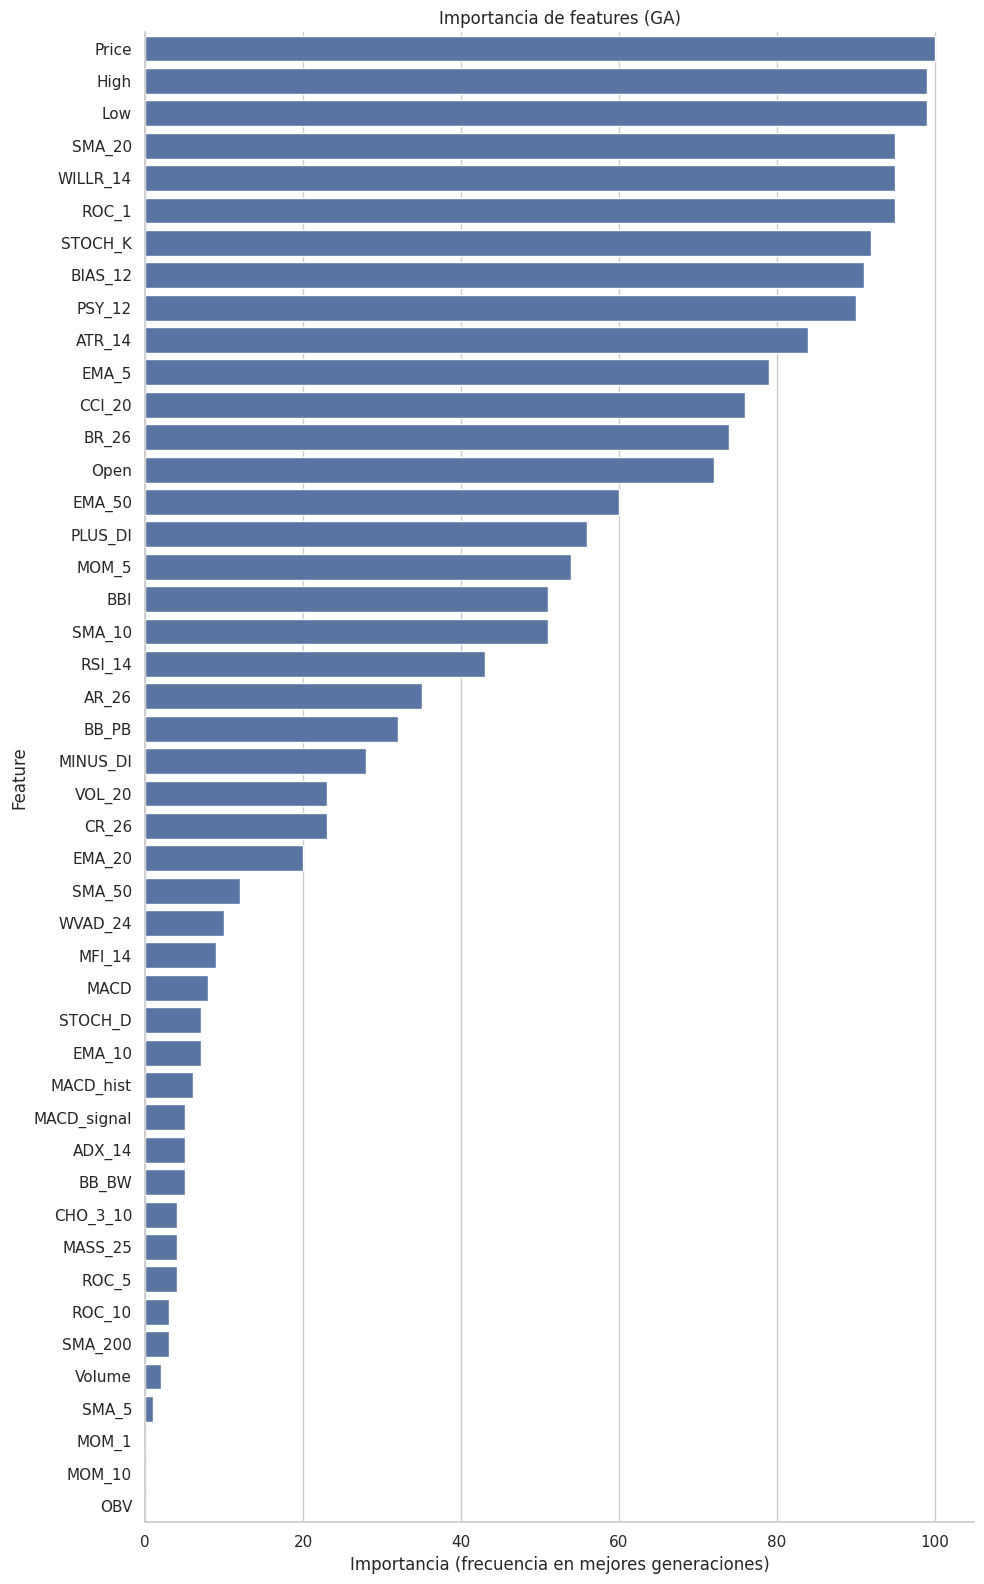

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# si vienes de feature_importance_frequency()
# ranking: pd.Series, name="freq_best_generations"

top_n = 46 # ajusta a gusto
plot_df = ranking.sort_values(ascending=False).head(top_n).reset_index()
plot_df.columns = ["feature", "importance"]

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, max(4, int(top_n*0.35))))
ax = sns.barplot(data=plot_df, x="importance", y="feature")
ax.set(
    title="Importancia de features (GA)",
    xlabel="Importancia (frecuencia en mejores generaciones)",
    ylabel="Feature"
)
sns.despine()
plt.tight_layout()
plt.show()


## Preparar datos para LSTM

In [23]:
from typing import Optional
from sklearn.preprocessing import MinMaxScaler

# 1) Target y limpieza: predecir PRECIO del día siguiente
def build_xy(features_df: pd.DataFrame):
    df = features_df.copy()
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.set_index("Date").sort_index()

    # Target: precio de cierre del día siguiente
    df["Price_next"] = df["Price"].shift(-1)

    # Limpieza: elimina filas con NaN en cualquier columna (incluyendo Price_next)
    df = df.dropna()

    # y = precio de mañana (sin escalar)
    y = df["Price_next"].astype(float)

    # X = todas las features, incluyendo Price actual
    X = df.drop(columns=["Price_next"])

    # elimina columnas constantes por seguridad
    const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
    if const_cols:
        X = X.drop(columns=const_cols)

    assert X.index.equals(y.index), "Desalineación temporal: los índices de X e y no difieren."

    return X, y


# 2) Splits por fecha, sin fuga
@dataclass
class SplitDates:
    train_end: str   # ej. "2013-12-31"
    val_end: str     # ej. "2015-12-31"
    test_end: Optional[str] = None   # ej. "2017-12-31"  (opcional)

def time_splits(X: pd.DataFrame, y: pd.Series, dates: SplitDates):
    idx = X.index
    train = idx <= pd.to_datetime(dates.train_end)
    val   = (idx > pd.to_datetime(dates.train_end)) & (idx <= pd.to_datetime(dates.val_end))
    test  = idx > pd.to_datetime(dates.val_end) if dates.test_end is None else (
            idx > pd.to_datetime(dates.val_end)) & (idx <= pd.to_datetime(dates.test_end))

    return (X.loc[train], y.loc[train]), (X.loc[val], y.loc[val]), (X.loc[test], y.loc[test])

# 3) Normalización: fit SOLO en train, usando MinMax
class TimeScaler:
    def __init__(self, feature_range=(0, 1)):
        self.scaler = MinMaxScaler(feature_range=feature_range)
        self.cols_: list[str] = []

    def fit(self, X_train: pd.DataFrame):
        self.scaler.fit(X_train.values)
        self.cols_ = list(X_train.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        missing = [c for c in self.cols_ if c not in X.columns]
        extra = [c for c in X.columns if c not in self.cols_]
        assert not missing, f"Faltan columnas para transformar: {missing}"
        if extra:
            print(f"[AVISO] Columnas extra ignoradas en transform: {extra}")
        X2 = X[self.cols_].values  # mismas columnas y orden
        return self.scaler.transform(X2)

class TimeScalerY:
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, y_train):
        self.scaler.fit(y_train.reshape(-1, 1))
        return self

    def transform(self, y):
        return self.scaler.transform(y.reshape(-1, 1)).flatten()

    def inverse(self, y_scaled):
        return self.scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()


# 4) Ventanas para LSTM, con fechas
def make_sequences(
    X_arr: np.ndarray,
    y_arr: np.ndarray,
    dates_arr: np.ndarray,
    lookback: int = 60,
):
    """
    Cada muestra: ventana [t-lookback+1 ... t] -> predice y[t],
    donde y[t] es el precio de cierre del día siguiente (Price_next en t).

    Devuelve:
      X_seq:   (n_samples, lookback, n_features)
      y_seq:   (n_samples,)
      d_seq:   (n_samples,) fecha correspondiente al último paso de la ventana
    """
    n = len(y_arr)
    X_seq, y_seq, d_seq = [], [], []

    for t in range(lookback - 1, n):
        X_seq.append(X_arr[t - lookback + 1:t + 1, :])
        y_seq.append(y_arr[t])
        d_seq.append(dates_arr[t])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(d_seq),
    )



# 5) Empaque completo para LSTM
@dataclass
class LSTMPrepConfig:
    # en el paper usan ventana de 5 días
    lookback: int = 5
    # horizon queda por compatibilidad, pero NO se usa en esta versión
    horizon: int = 1
    # si quieres top-k features del GA, pasa una lista en selected_features
    selected_features: list | None = None


def prepare_lstm_data(
    features_df: pd.DataFrame,
    split_dates: SplitDates,
    cfg: LSTMPrepConfig = LSTMPrepConfig(),
):
    # X,y crudos (y = Price_next en escala REAL)
    X, y = build_xy(features_df)

    # opcional: filtrar por ranking GA
    if cfg.selected_features is not None:
        keep = [c for c in cfg.selected_features if c in X.columns]
        X = X[keep]
        assert list(X.columns) == keep, "El orden/subconjunto de columnas no coincide con 'selected_features'."

    # splits a nivel de filas (para saber qué es train y fittear los scalers SOLO con train)
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = time_splits(X, y, split_dates)

    # ---------- Escalado X (features) ----------
    scaler_x = TimeScaler().fit(X_tr)
    X_all_scaled = scaler_x.transform(X)

    # ---------- Escalado y (target: Price_next) ----------
    y_all = y.values.astype(np.float32)
    y_tr_arr = y_tr.values.astype(np.float32)

    scaler_y = TimeScalerY().fit(y_tr_arr)
    y_all_scaled = scaler_y.transform(y_all)

    # ---------- Construir TODAS las secuencias, con sus fechas asociadas ----------
    dates_all = X.index.to_numpy()

    X_seq, y_seq, d_seq = make_sequences(
        X_all_scaled,
        y_all_scaled,   # OJO: y ya está ESCALADO
        dates_all,
        lookback=cfg.lookback,
    )

    # ---------- Split en train/val/test según la fecha del ÚLTIMO paso de la ventana ----------
    train_end_dt = pd.to_datetime(split_dates.train_end)
    val_end_dt = pd.to_datetime(split_dates.val_end)
    test_end_dt = pd.to_datetime(split_dates.test_end) if split_dates.test_end is not None else None

    train_mask = d_seq <= train_end_dt
    val_mask = (d_seq > train_end_dt) & (d_seq <= val_end_dt)
    if test_end_dt is None:
        test_mask = d_seq > val_end_dt
    else:
        test_mask = (d_seq > val_end_dt) & (d_seq <= test_end_dt)

    Xtr_seq, ytr_seq = X_seq[train_mask], y_seq[train_mask]
    Xva_seq, yva_seq = X_seq[val_mask], y_seq[val_mask]
    Xte_seq, yte_seq = X_seq[test_mask], y_seq[test_mask]

    out = {
        "X_train": Xtr_seq,
        "y_train": ytr_seq,
        "X_val":   Xva_seq,
        "y_val":   yva_seq,
        "X_test":  Xte_seq,
        "y_test":  yte_seq,
        # devolvemos ambos scalers:
        "scaler_x":  scaler_x,
        "scaler_y":  scaler_y,
        "feature_cols": list(X.columns),
        "lookback": cfg.lookback,
        # horizon lo dejamos informativo: siempre 1 día hacia delante en precio
        "horizon": 1,
        "dates_seq": d_seq,  # por si quieres inspeccionar las fechas de las ventanas
    }
    return out



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, Sequential
import numpy as np
from typing import Optional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# === utilidades LSTM ===

# 2) Splits por fecha, sin fuga
@dataclass
class SplitDates:
    train_end: str   # ej. "2013-12-31"
    val_end: str     # ej. "2015-12-31"
    test_end: Optional[str] = None   # ej. "2017-12-31"  (opcional)

def time_splits(X: pd.DataFrame, y: pd.Series, dates: SplitDates):
    idx = X.index
    train = idx <= pd.to_datetime(dates.train_end)
    val   = (idx > pd.to_datetime(dates.train_end)) & (idx <= pd.to_datetime(dates.val_end))
    test  = idx > pd.to_datetime(dates.val_end) if dates.test_end is None else (
            idx > pd.to_datetime(dates.val_end)) & (idx <= pd.to_datetime(dates.test_end))

    return (X.loc[train], y.loc[train]), (X.loc[val], y.loc[val]), (X.loc[test], y.loc[test])

# 3) Normalización: fit SOLO en train, usando MinMax
class TimeScaler:
    def __init__(self, feature_range=(0, 1)):
        self.scaler = MinMaxScaler(feature_range=feature_range)
        self.cols_: list[str] = []

    def fit(self, X_train: pd.DataFrame):
        self.scaler.fit(X_train.values)
        self.cols_ = list(X_train.columns)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        missing = [c for c in self.cols_ if c not in X.columns]
        extra = [c for c in X.columns if c not in self.cols_]
        assert not missing, f"Faltan columnas para transformar: {missing}"
        if extra:
            print(f"[AVISO] Columnas extra ignoradas en transform: {extra}")
        X2 = X[self.cols_].values  # mismas columnas y orden
        return self.scaler.transform(X2)

class TimeScalerY:
    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, y_train):
        self.scaler.fit(y_train.reshape(-1, 1))
        return self

    def transform(self, y):
        return self.scaler.transform(y.reshape(-1, 1)).flatten()

    def inverse(self, y_scaled):
        return self.scaler.inverse_transform(y_scaled.reshape(-1,1)).flatten()


# 4) Ventanas para LSTM, con fechas
def make_sequences(
    X_arr: np.ndarray,
    y_arr: np.ndarray,
    dates_arr: np.ndarray,
    lookback: int = 60,
):
    """
    Cada muestra: ventana [t-lookback+1 ... t] -> predice y[t],
    donde y[t] es el precio de cierre del día siguiente (Price_next en t).

    Devuelve:
      X_seq:   (n_samples, lookback, n_features)
      y_seq:   (n_samples,)
      d_seq:   (n_samples,) fecha correspondiente al último paso de la ventana
    """
    n = len(y_arr)
    X_seq, y_seq, d_seq = [], [], []

    for t in range(lookback - 1, n):
        X_seq.append(X_arr[t - lookback + 1:t + 1, :])
        y_seq.append(y_arr[t])
        d_seq.append(dates_arr[t])

    return (
        np.array(X_seq, dtype=np.float32),
        np.array(y_seq, dtype=np.float32),
        np.array(d_seq),
    )



# 5) Empaque completo para LSTM
@dataclass
class LSTMPrepConfig:
    # en el paper usan ventana de 5 días
    lookback: int = 5
    # horizon queda por compatibilidad, pero NO se usa en esta versión
    horizon: int = 1
    # si quieres top-k features del GA, pasa una lista en selected_features
    selected_features: list | None = None


def prepare_lstm_data(
    features_df: pd.DataFrame,
    split_dates: SplitDates,
    cfg: LSTMPrepConfig = LSTMPrepConfig(),
):
    # X,y crudos (y = Price_next en escala REAL)
    X, y = build_xy(features_df)

    # opcional: filtrar por ranking GA
    if cfg.selected_features is not None:
        keep = [c for c in cfg.selected_features if c in X.columns]
        X = X[keep]
        assert list(X.columns) == keep, "El orden/subconjunto de columnas no coincide con 'selected_features'."

    # splits a nivel de filas (para saber qué es train y fittear los scalers SOLO con train)
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = time_splits(X, y, split_dates)

    # ---------- Escalado X (features) ----------
    scaler_x = TimeScaler().fit(X_tr)
    X_all_scaled = scaler_x.transform(X)

    # ---------- Escalado y (target: Price_next) ----------
    y_all = y.values.astype(np.float32)
    y_tr_arr = y_tr.values.astype(np.float32)

    scaler_y = TimeScalerY().fit(y_tr_arr)
    y_all_scaled = scaler_y.transform(y_all)

    # ---------- Construir TODAS las secuencias, con sus fechas asociadas ----------
    dates_all = X.index.to_numpy()

    X_seq, y_seq, d_seq = make_sequences(
        X_all_scaled,
        y_all_scaled,   # OJO: y ya está ESCALADO
        dates_all,
        lookback=cfg.lookback,
    )

    # ---------- Split en train/val/test según la fecha del ÚLTIMO paso de la ventana ----------
    train_end_dt = pd.to_datetime(split_dates.train_end)
    val_end_dt = pd.to_datetime(split_dates.val_end)
    test_end_dt = pd.to_datetime(split_dates.test_end) if split_dates.test_end is not None else None

    train_mask = d_seq <= train_end_dt
    val_mask = (d_seq > train_end_dt) & (d_seq <= val_end_dt)
    if test_end_dt is None:
        test_mask = d_seq > val_end_dt
    else:
        test_mask = (d_seq > val_end_dt) & (d_seq <= test_end_dt)

    Xtr_seq, ytr_seq = X_seq[train_mask], y_seq[train_mask]
    Xva_seq, yva_seq = X_seq[val_mask], y_seq[val_mask]
    Xte_seq, yte_seq = X_seq[test_mask], y_seq[test_mask]

    out = {
        "X_train": Xtr_seq,
        "y_train": ytr_seq,
        "X_val":   Xva_seq,
        "y_val":   yva_seq,
        "X_test":  Xte_seq,
        "y_test":  yte_seq,
        # devolvemos ambos scalers:
        "scaler_x":  scaler_x,
        "scaler_y":  scaler_y,
        "feature_cols": list(X.columns),
        "lookback": cfg.lookback,
        # horizon lo dejamos informativo: siempre 1 día hacia delante en precio
        "horizon": 1,
        "dates_seq": d_seq,  # por si quieres inspeccionar las fechas de las ventanas
    }
    return out

def make_lstm(input_shape, units=128, dropout=0.2, lr=1e-3):
    """
    LSTM estilo paper:
      - 1 capa LSTM con 128 unidades
      - Dropout 0.2
      - Salida densa de 1 neurona (precio escalado)
    """
    m = Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    m.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")],
    )
    return m


# ----------------------------------------------------------
# Evaluación LSTM en ESCALA NORMALIZADA
# ----------------------------------------------------------
def eval_set(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Entrena un LSTM y devuelve MSE / RMSE en ESCALA NORMALIZADA de y.
    """
    tf.keras.utils.set_random_seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr = prep["X_train"], prep["y_train"]   # ytr escalado
    Xva, yva = prep["X_val"],   prep["y_val"]
    Xte, yte = prep["X_test"],  prep["y_test"]

    model = make_lstm(Xtr.shape[1:])
    es = callbacks.EarlyStopping(monitor="val_rmse", patience=10, restore_best_weights=True)

    model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=64,
        callbacks=[es],
        verbose=0,
    )

    loss_tr, rmse_tr = model.evaluate(Xtr, ytr, verbose=0)
    loss_va, rmse_va = model.evaluate(Xva, yva, verbose=0)
    loss_te, rmse_te = model.evaluate(Xte, yte, verbose=0)

    return {
        "train_rmse": float(rmse_tr),
        "val_rmse":   float(rmse_va),
        "test_rmse":  float(rmse_te),
        "train_mse":  float(loss_tr),
        "val_mse":    float(loss_va),
        "test_mse":   float(loss_te),
    }

def eval_multirun(feature_list, splits, base_features_df, runs=3, lookback=5, seed0=123):
    out = [eval_set(feature_list, splits, base_features_df, lookback, seed0 + i) for i in range(runs)]
    df = pd.DataFrame(out)
    return {
        # RMSE (target ESCALADO)
        "val_mean":  df["val_rmse"].mean(),
        "val_std":   df["val_rmse"].std(ddof=1),
        "test_mean": df["test_rmse"].mean(),
        "test_std":  df["test_rmse"].std(ddof=1),
        # MSE (target ESCALADO)
        "val_mse_mean":  df["val_mse"].mean(),
        "val_mse_std":   df["val_mse"].std(ddof=1),
        "test_mse_mean": df["test_mse"].mean(),
        "test_mse_std":  df["test_mse"].std(ddof=1),
        "runs": runs,
    }

# === conjuntos top/bottom/random por k ===
def compare_top_bottom_random(ranking_series: pd.Series, base_features_df: pd.DataFrame, splits, ks=(5,10,20,30), runs=3):
    results = []
    feats_all = list(ranking_series.index)
    for k in ks:
        topk = feats_all[:k]
        bottomk = feats_all[-k:]
        rng = np.random.default_rng(7)
        randk = rng.choice(feats_all, size=k, replace=False).tolist()

        for label, flist in [("top", topk), ("bottom", bottomk), ("random", randk)]:
            res = eval_multirun(flist, splits, base_features_df, runs=runs)
            results.append({"k": k, "set": label, **res})
    return pd.DataFrame(results)




# Comparación con otros modelos

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

def prepare_tabular_from_lstm_prep(prep_dict):
    def _flat(Xseq):
        n, L, f = Xseq.shape
        return Xseq.reshape(n, L * f)

    Xtr = _flat(prep_dict["X_train"])
    Xva = _flat(prep_dict["X_val"])
    Xte = _flat(prep_dict["X_test"])
    ytr = prep_dict["y_train"]
    yva = prep_dict["y_val"]
    yte = prep_dict["y_test"]
    return Xtr, ytr, Xva, yva, Xte, yte 


def eval_lstm_once(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Entrena UN LSTM y devuelve métricas en ESCALA NORMALIZADA.
    """
    tf.keras.utils.set_random_seed(seed)
    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr = prep["X_train"], prep["y_train"]
    Xva, yva = prep["X_val"],   prep["y_val"]
    Xte, yte = prep["X_test"],  prep["y_test"]

    model = make_lstm(Xtr.shape[1:])
    es = callbacks.EarlyStopping(monitor="val_rmse", patience=10, restore_best_weights=True)

    model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=100,
        batch_size=64,
        callbacks=[es],
        verbose=0,
    )

    loss_tr, rmse_tr = model.evaluate(Xtr, ytr, verbose=0)
    loss_va, rmse_va = model.evaluate(Xva, yva, verbose=0)
    loss_te, rmse_te = model.evaluate(Xte, yte, verbose=0)

    return {
        "train_rmse": float(rmse_tr),
        "val_rmse":   float(rmse_va),
        "test_rmse":  float(rmse_te),
        "train_mse":  float(loss_tr),
        "val_mse":    float(loss_va),
        "test_mse":   float(loss_te),
    }

def eval_lstm_multirun(feature_list, splits, base_features_df, runs=3, lookback=5, seed0=123):
    res = [eval_lstm_once(feature_list, splits, base_features_df, lookback, seed0 + i) for i in range(runs)]
    df = pd.DataFrame(res)
    return {
        "val_mean":       df["val_rmse"].mean(),
        "val_std":        df["val_rmse"].std(ddof=1),
        "test_mean":      df["test_rmse"].mean(),
        "test_std":       df["test_rmse"].std(ddof=1),
        "val_mse_mean":   df["val_mse"].mean(),
        "val_mse_std":    df["val_mse"].std(ddof=1),
        "test_mse_mean":  df["test_mse"].mean(),
        "test_mse_std":   df["test_mse"].std(ddof=1),
        "runs": runs,
    }


# ----------------------------------------------------------
# Naive en ESCALA NORMALIZADA
# ----------------------------------------------------------
def eval_naive_persistence(features_df: pd.DataFrame, splits: SplitDates):
    """
    Baseline ingenuo (persistence): predice Price_next[t] ≈ Price[t],
    usando MISMO target y MISMO tipo de escalado MinMax que los demás modelos.
    Devuelve MSE en ESCALA NORMALIZADA.
    """
    X, y = build_xy(features_df)

    price_t = X["Price"].astype(float).values
    y_all = y.values.astype(np.float32)

    idx = X.index
    train_mask = idx <= pd.to_datetime(splits.train_end)
    val_mask   = (idx > pd.to_datetime(splits.train_end)) & (idx <= pd.to_datetime(splits.val_end))
    test_mask  = idx > pd.to_datetime(splits.val_end) if splits.test_end is None else (
                 (idx > pd.to_datetime(splits.val_end)) & (idx <= pd.to_datetime(splits.test_end)))

    # Escalador de y: fit SOLO en y_train
    y_train = y_all[train_mask]
    scaler_y = TimeScalerY().fit(y_train)

    y_scaled = scaler_y.transform(y_all)
    price_t_scaled = scaler_y.transform(price_t)

    def _mse(mask):
        return mean_squared_error(y_scaled[mask], price_t_scaled[mask])

    return {
        "train_mse": _mse(train_mask),
        "val_mse":   _mse(val_mask),
        "test_mse":  _mse(test_mask),
    }

# ----------------------------------------------------------
# RF baseline (MSE en ESCALA NORMALIZADA)
# ----------------------------------------------------------
def eval_rf_baseline(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Random Forest sobre ventanas (flattened).
    MSE en ESCALA NORMALIZADA de y.
    """
    np.random.seed(seed)

    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )

    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=seed,
    )
    rf.fit(Xtr, ytr)

    pr_tr = rf.predict(Xtr)
    pr_va = rf.predict(Xva)
    pr_te = rf.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }

# ----------------------------------------------------------
# PCA-SVR baseline (MSE en ESCALA NORMALIZADA)
# ----------------------------------------------------------
def eval_pca_svr_baseline(feature_list, splits, base_features_df, lookback=5, seed=123):
    """
    Aproximación al PCA-SVM del paper: PCA + SVR RBF.
    Devuelve MSE en ESCALA NORMALIZADA del target.
    """
    np.random.seed(seed)

    prep = prepare_lstm_data(
        features_df=base_features_df,
        split_dates=splits,
        cfg=LSTMPrepConfig(lookback=lookback, horizon=1, selected_features=feature_list),
    )
    Xtr, ytr, Xva, yva, Xte, yte = prepare_tabular_from_lstm_prep(prep)

    model = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=seed)),  # conservar 95% varianza
        ("svr", SVR(kernel="rbf", C=10.0, epsilon=0.01)),
    ])
    model.fit(Xtr, ytr)

    pr_tr = model.predict(Xtr)
    pr_va = model.predict(Xva)
    pr_te = model.predict(Xte)

    return {
        "train_mse": mean_squared_error(ytr, pr_tr),
        "val_mse":   mean_squared_error(yva, pr_va),
        "test_mse":  mean_squared_error(yte, pr_te),
    }




In [26]:
# Fechas
splits = SplitDates(
    train_end="2001-01-01",
    val_end="2003-12-31",
    test_end="2004-12-31",
)

# Naïve
naive_res = eval_naive_persistence(features, splits)
print("Naive:", naive_res)

# Selección GA (top-k)
k = 20
selected = list(ranking.head(k).index)

rf_res = eval_rf_baseline(selected, splits, features, lookback=5)
pca_svr_res = eval_pca_svr_baseline(selected, splits, features, lookback=5)

lstm_ga_res = eval_multirun(
    feature_list=selected,
    splits=splits,
    base_features_df=features,
    runs=3,
    lookback=5,
    seed0=123,
)

all_features = [c for c in features.columns if c != "Price"]
lstm_all_res = eval_multirun(
    feature_list=all_features,
    splits=splits,
    base_features_df=features,
    runs=3,
    lookback=5,
    seed0=200,
)

resumen = pd.DataFrame([
    {
        "modelo": "Naive",
        "val_mse": naive_res["val_mse"],
        "test_mse": naive_res["test_mse"],
    },
    {
        "modelo": "RF (GA k=20)",
        "val_mse": rf_res["val_mse"],
        "test_mse": rf_res["test_mse"],
    },
    {
        "modelo": "PCA-SVR (GA k=20)",
        "val_mse": pca_svr_res["val_mse"],
        "test_mse": pca_svr_res["test_mse"],
    },
    {
        "modelo": "LSTM (GA k=20)",
        "val_mse": lstm_ga_res["val_mse_mean"],
        "test_mse": lstm_ga_res["test_mse_mean"],
    },
    {
        "modelo": "LSTM (todas)",
        "val_mse": lstm_all_res["val_mse_mean"],
        "test_mse": lstm_all_res["test_mse_mean"],
    },
])

print(resumen)


Naive: {'train_mse': 0.00018905588482225814, 'val_mse': 8.916109646574155e-05, 'test_mse': 0.0002227002373311212}
              modelo   val_mse  test_mse
0              Naive  0.000089  0.000223
1       RF (GA k=20)  0.000104  0.000524
2  PCA-SVR (GA k=20)  0.000143  0.003252
3     LSTM (GA k=20)  0.000100  0.000380
4       LSTM (todas)  0.000117  0.000683


In [27]:
# ks que quieres probar para GA-LSTM
ks = [5, 10, 20, 30]
runs = 3
lookback = 5

# --- modelos que NO dependen de k (se calculan una sola vez) ---
naive_res = eval_naive_persistence(features, splits)

all_features = [c for c in features.columns if c != "Price"]

rf_all_res = eval_rf_baseline(all_features, splits, features, lookback=lookback)
pca_all_res = eval_pca_svr_baseline(all_features, splits, features, lookback=lookback)
lstm_all_res = eval_multirun(
    feature_list=all_features,
    splits=splits,
    base_features_df=features,
    runs=runs,
    lookback=lookback,
    seed0=200,
)

filas = []

# Baselines “puros”
filas.append({
    "modelo": "Naive",
    "k": "-",
    "val_mse": naive_res["val_mse"],
    "test_mse": naive_res["test_mse"],
})

filas.append({
    "modelo": "RF (todas)",
    "k": "-",
    "val_mse": rf_all_res["val_mse"],
    "test_mse": rf_all_res["test_mse"],
})

filas.append({
    "modelo": "PCA-SVR (todas)",
    "k": "-",
    "val_mse": pca_all_res["val_mse"],
    "test_mse": pca_all_res["test_mse"],
})

filas.append({
    "modelo": "LSTM (todas)",
    "k": "-",
    "val_mse": lstm_all_res["val_mse_mean"],
    "test_mse": lstm_all_res["test_mse_mean"],
})

# --- GA-LSTM para distintos k (top-k del ranking GA) ---
feats_ordenados = list(ranking.index)   # ranking = Series de feature_importance_frequency()

for k in ks:
    selected = feats_ordenados[:k]
    lstm_ga_res = eval_multirun(
        feature_list=selected,
        splits=splits,
        base_features_df=features,
        runs=runs,
        lookback=lookback,
        seed0=123,     # o el que quieras
    )
    filas.append({
        "modelo": f"GA-LSTM (k={k})",
        "k": k,
        "val_mse": lstm_ga_res["val_mse_mean"],
        "test_mse": lstm_ga_res["test_mse_mean"],
    })

tabla_baselines = pd.DataFrame(filas)

# Si quieres que se vea bonito y sin índice:
print(tabla_baselines.to_string(index=False))


         modelo  k  val_mse  test_mse
          Naive  - 0.000089  0.000223
     RF (todas)  - 0.000098  0.000535
PCA-SVR (todas)  - 0.000679  0.015960
   LSTM (todas)  - 0.000117  0.000683
  GA-LSTM (k=5)  5 0.000108  0.000364
 GA-LSTM (k=10) 10 0.000103  0.000319
 GA-LSTM (k=20) 20 0.000100  0.000380
 GA-LSTM (k=30) 30 0.000105  0.000430
